In [1]:
import pandas as pd
import numpy as np
import LOESS
import matplotlib.pyplot as plt

Load the training and test sets.

In [2]:
training_data = pd.read_csv('quasar_train.csv')
test_data = pd.read_csv('quasar_test.csv')

In [3]:
X = np.zeros((len(training_data.columns), 2))
X[:,0] = 1   # all elements of the first column of X are 1
X[:,1] = np.array(training_data.columns.values).astype(float)

In [4]:
def smoothed_spectra(data, X, tau = 5):
    x = X[:,1]     # these are the (fixed) inputs used in locally weighted regressions
    m = len(data)
    n = len(x)     # number of wavelengths, same notation as in the problem set
    smoothed_spectra = np.zeros((m, n))
    for i in range(m):
        y = np.array(data.iloc[[i]]).T
        y_smoothed = LOESS.locally_weighted_linear_reg(x = x, X = X, y = y, tau = tau)
        smoothed_spectra[i,:] = y_smoothed.T
    return smoothed_spectra

Apply smoothing found in part (b) to both training and test sets. The smoothed spectra will be used in the remaining parts.

In [5]:
smoothed_spectra_train = smoothed_spectra(training_data, X)
smoothed_spectra_test = smoothed_spectra(test_data, X)

###################################################################################################################

In [6]:
def ker(t):
    return max(1-t, 0)

In [7]:
# Some useful parameters
m_train = len(training_data)
m_test = len(test_data)
n_left = 50
n_right = 300

In [8]:
def find_neighb_and_max(f, training_data, k = 3, n_right = 300):
    '''
    Input:  (i)   f, a given spectrum,
            (ii)  training data contains all spectra in the training set,
            (iii) k, desired number of indices in the neighborhood of f,
            (iv)  n_right = number of wavelengths on the right of Lyman-alpha line.
    Output: return
            (i)   neighb_indices, the indices corresponding to the k spectra closest to f,
            (ii)  neighb_metric, the squared distance between f and spectra in neighb(f)
            (iii) max_metric, the squared distance between f and the spectrum most distant from f
    '''
    f_right = f[-n_right:]
    squared_distances = np.sum((training_data[:,-n_right:] - f_right)**2 ,axis = 1)
    
    neighb_indices = np.argpartition(squared_distances, k)[:k]
    neighb_metric = squared_distances[neighb_indices]
    max_index = np.argmax(squared_distances)
    max_metric = squared_distances[max_index]
    
    return neighb_indices, neighb_metric, max_metric

In [9]:
def f_left_hat(f, training_data, k = 3, n_left = 50, n_right = 300):
    '''
    Input:  (i)   f, a given spectrum,
            (ii)  training data contains all spectra in the training set,
            (iii) k, desired number of indices in the neighborhood of f,
            (iv)  n_left, number of wavelengths within the Lyman-alpha forest region
            (v)   n_right, number of wavelengths on the right of Lyman-alpha line.
    Output: return
            f_left_hat, the nonparametric functional regression estimator of f_left (left portion of the given f)
    '''    
    
    weights = np.zeros((k, 1))
    neighb_indices, neighb_metric, max_metric = find_neighb_and_max(f, training_data, k = k, n_right = n_right)
    for i in range(k):
        weights[i,0] = ker(neighb_metric[i]/max_metric)
    f_left_neighb = training_data[neighb_indices,:n_left]
    f_left_hat = np.matmul(weights.T, f_left_neighb) / sum(weights)
    
    return f_left_hat

For the training set, compute the estimator f_left_hat for each training example j = 1,...,m_train. The results are stored in f_left_hat_train (a m_train x n_left matrix).

In [10]:
f_left_hat_train = np.zeros((m_train, n_left))
for j in range(m_train):
    f = smoothed_spectra_train[j,:]
    f_left_hat_train[j,:] = f_left_hat(f = f, training_data = smoothed_spectra_train)
print(f_left_hat_train)

[[0.95146105 0.98409078 1.01225449 ... 1.05467279 1.05341071 1.05567099]
 [1.2654473  1.31769261 1.34673052 ... 1.04557044 1.05943557 1.07919571]
 [0.46620161 0.56055059 0.64247097 ... 0.99404862 1.00842528 1.02928999]
 ...
 [0.57504224 0.64620473 0.69587859 ... 0.97302349 0.97703817 0.98795494]
 [0.09381072 0.20515599 0.32552023 ... 1.12085167 1.13926718 1.1649192 ]
 [1.4488917  1.3656172  1.28232177 ... 1.11384246 1.12615486 1.14117351]]


Computer the error for each training example.

In [11]:
training_error = np.sum((f_left_hat_train - smoothed_spectra_train[:,:n_left])**2, axis = 1)
print(training_error)

[1.325294   1.12749272 6.1556964  0.11105456 0.40855764 1.24816473
 0.48173769 1.24978635 1.3226846  1.24773746 1.38566604 0.0806775
 0.82472713 1.71502647 1.04537061 1.59637989 0.74476006 0.86285272
 0.10768188 0.61561577 0.97917577 0.34118958 1.52960039 1.19713388
 0.91629868 1.86106613 1.31668733 1.31286651 2.50979339 1.05101077
 1.55437003 0.58049781 2.9372594  0.78463672 0.1925452  1.59308126
 1.42152984 0.16645379 0.4559788  0.92891645 0.74857197 0.63980526
 1.71805739 0.67488205 0.88351688 0.2476439  2.46760181 0.54854143
 0.19816866 0.95993466 2.96773531 0.51608491 0.75935742 1.63291766
 0.46353399 0.3649539  0.74417534 0.28439757 0.24431154 0.93770007
 0.83146791 1.06702387 0.60132444 2.16464086 0.50100315 0.67800417
 1.44138242 0.45602066 0.68714993 0.66539846 0.64463696 1.11084087
 1.07597067 2.64523868 0.29823992 1.08204351 1.69571353 1.19469169
 1.71049595 0.23692866 0.31428476 1.39001921 0.50465562 0.9182183
 0.8257975  1.46448247 0.35453244 0.54326685 2.03283181 0.684664

Compute the average training error.

In [12]:
average_training_error = sum(training_error)/len(training_error)
print(average_training_error)

1.0663958023823594


###################################################################################################################

For the test set, compute the estimator f_left_hat for each training example j = 1,...,m_test. The results are stored in f_left_hat_test (a m_test x n_left matrix).

In [13]:
f_left_hat_test = np.zeros((m_test, n_left))
for j in range(m_test):
    f = smoothed_spectra_test[j,:]
    f_left_hat_test[j,:] = f_left_hat(f = f, training_data = smoothed_spectra_train)
print(f_left_hat_test)

[[1.05779654 1.0392748  1.01344001 ... 1.02851882 1.03705917 1.05320896]
 [0.66717209 0.80490248 0.91989562 ... 1.04970597 1.06714675 1.08566425]
 [0.40807136 0.54551486 0.66111567 ... 1.12505545 1.12229297 1.1199594 ]
 ...
 [0.85122834 0.86955193 0.891719   ... 1.18805446 1.17741323 1.16976733]
 [0.56980645 0.62503838 0.68115263 ... 1.04653933 1.05504964 1.07320385]
 [0.82137191 0.88955105 0.94602853 ... 1.01652496 1.03896532 1.06573871]]


Computer the error for each test example.

In [14]:
test_error = np.sum((f_left_hat_test - smoothed_spectra_test[:,:n_left])**2, axis = 1)
print(test_error)

[ 0.29401478  3.9746809   2.60674828  1.38126953  6.07255691  2.66317197
  2.24585214  1.3569354   8.37992567  0.83419717 12.51940012  3.89160291
  0.85543276  4.92064121  3.63057172  0.58252314  1.76390175  1.28532057
  1.70323179  0.91615686  2.98328607  0.29554625  2.01074939  4.35949318
  0.79247367  6.04187028  1.26107972  6.20086315  1.91749608  1.26715475
  5.04034864  1.46010126  3.15359778  0.69706331  2.09165624  2.96534612
  2.19405569  1.22730362  1.11234868  1.57747818  2.59167208  1.85581581
  2.04742962  1.52699513  1.07249648  2.03254269  0.44658294  2.09487739
  1.78125303  9.52136617]


Compute the average test error.

In [15]:
average_test_error = sum(test_error)/len(test_error)
print(average_test_error)

2.7099695794129364


Plot entire amooth spectrum and the fitted curve for test example 1 & 6.

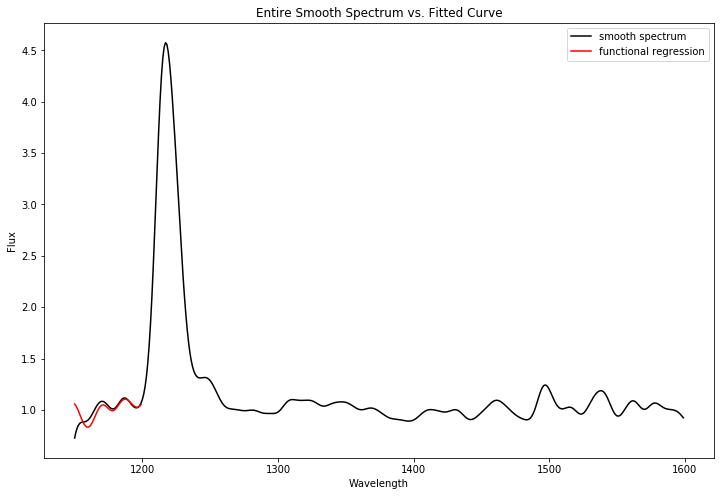

In [16]:
fig = plt.figure(1, figsize=(12,8))
x = X[:,1]

# Plot the entire smooth spectrum and the fitted f_left_hat for test example 1
plt.plot(x, smoothed_spectra_test[0,:], color = 'black', label = 'smooth spectrum')
plt.plot(x[:n_left], f_left_hat_test[0,:], color = 'red', label = 'functional regression')

# Other settings
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title('Entire Smooth Spectrum vs. Fitted Curve')
plt.legend(loc = 'upper right')
plt.show()

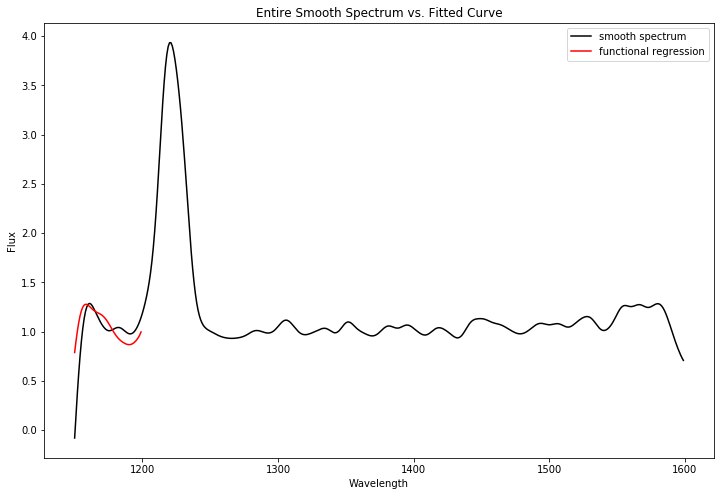

In [17]:
fig = plt.figure(1, figsize=(12,8))
x = X[:,1]

# Plot the entire smooth spectrum and the fitted f_left_hat for test example 6
plt.plot(x, smoothed_spectra_test[5,:], color = 'black', label = 'smooth spectrum')
plt.plot(x[:n_left], f_left_hat_test[5,:], color = 'red', label = 'functional regression')

# Other settings
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title('Entire Smooth Spectrum vs. Fitted Curve')
plt.legend(loc = 'upper right')
plt.show()